#### Part-1: Face Detection from Images

##### CONTEXT: 
Company owns a movie application and repository which caters movie streaming to millions of users who on subscription basis.
Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the
movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision
and multimedia experts who need to detect faces from screen shots from the movie scene.

In [1]:
#Import libraries
import os,cv2
%matplotlib inline
import matplotlib.pyplot as plt # Data Visualization
import pandas as pd # Data processing
import seaborn as sns # Data Visualization
import numpy as np # Linear Algebra
import tensorflow as tf #Tensor Flow
from sklearn import preprocessing #preprocessing libraries from sklearn

from google.colab.patches import cv2_imshow #google colab for cv2.imshow

#### 1. Import the dataset and read

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


Create a directory for the project (e.g detection) and move to project directory.

In [3]:
#Come to the home directory
%cd /content

/content


In [4]:
#Create a folder for your project e.g in this case, detection. You can choose any name for the folder 
!mkdir detection

#Go to the project folder
%cd detection

/content/detection


In [5]:
data = np.load('/gdrive/MyDrive/ACV Project 1 Dataset /Dataset- Images.npy', allow_pickle= True)

In [6]:
data.shape

(409, 2)

* There are 409 rows and 2 columns in the dataset

In [7]:
data[0][0].shape # checking the first column/column shape

(333, 650, 3)

In [8]:
data[0][1] # checking the second column/column shape

[{'imageHeight': 333,
  'imageWidth': 650,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063},
   {'x': 0.1723076923076923, 'y': 0.45345345345345345}]},
 {'imageHeight': 333,
  'imageWidth': 650,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913},
   {'x': 0.6584615384615384, 'y': 0.46846846846846846}]}]

In [9]:
data[0][0]

array([[[42, 37, 34],
        [56, 51, 48],
        [71, 66, 63],
        ...,
        [23, 33, 34],
        [26, 36, 37],
        [28, 38, 39]],

       [[40, 35, 32],
        [51, 46, 43],
        [64, 59, 56],
        ...,
        [27, 36, 35],
        [24, 33, 32],
        [26, 35, 34]],

       [[43, 38, 35],
        [51, 46, 43],
        [61, 56, 53],
        ...,
        [28, 30, 27],
        [33, 35, 32],
        [35, 37, 34]],

       ...,

       [[56, 47, 40],
        [57, 48, 41],
        [61, 52, 45],
        ...,
        [67, 48, 42],
        [55, 35, 28],
        [60, 40, 33]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [60, 40, 33],
        [54, 34, 27]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [70, 50, 43],
        [64, 44, 37]]], dtype=uint8)

* the first column is the color image and second column are the data about face in that corresponing image.

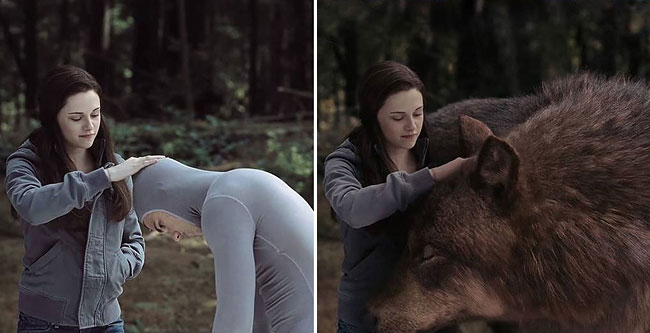

In [10]:
tf.keras.preprocessing.image.array_to_img(data[0][0])

#### 2. Create features (images) and labels (mask) for face using that data.

Set image size

In [11]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

In [12]:
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
originals = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    originals[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

In [13]:
#Of 409 images use 400 for train and 9 for test
X_train = originals[:400]
y_train = masks[:400]
X_test = originals[400:]
y_test = masks[400:]

In [14]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(400, 224, 224, 3)
(9, 224, 224, 3)
(400, 224, 224)
(9, 224, 224)


#### 3. Mask detection model:
● Design a face mask detection model.
Hint: Use U-net along with pre-trained transfer learning models
● Design your own Dice Coefficient and Loss function.
● Train, tune and test the model.
● Evaluate the model using testing data.

##### Model Design

First we have to split images between training and test. Then we can use that information to split dataframe between training and test. This will make sure objects from same image are not split between training and test.

In [15]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Reshape, UpSampling2D, Concatenate, Conv2D
from tensorflow.keras.models import Model

def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable
  
    block0 = model.get_layer("conv_pw_1_relu").output
    block1 = model.get_layer("conv_pw_3_relu").output
    block2 = model.get_layer("conv_pw_5_relu").output
    block3 = model.get_layer("conv_pw_11_relu").output
    block4 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block4), block3])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block2])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block1])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block0])
    print(x.shape)
    x = UpSampling2D()(x)
    print(x.shape)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)
    print(x.shape)

    return Model(inputs=model.input, outputs=x)

In [16]:
model = create_model()

17235968/17225924 [==============================] - 0s 0us/step
(None, 14, 14, 1536)
(None, 28, 28, 1792)
(None, 56, 56, 1920)
(None, 112, 112, 1984)
(None, 224, 224, 1984)
(None, 224, 224)


In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 112, 112, 32) 0           conv1_bn[0][0]                   
______________________________________________________________________________________________

##### Define Dice Coefficient

In [18]:
from tensorflow import reduce_sum
from tensorflow.keras.backend import epsilon

def dice_coefficient(y_true, y_pred):
    numerator = 2 * reduce_sum(y_true * y_pred)
    denominator = reduce_sum(y_true + y_pred)
    return numerator / (denominator + epsilon())

##### Define Loss Function

In [19]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log

def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

##### Compile model using above defined metrics and loss

In [20]:
model.compile(loss=loss, optimizer='adam', metrics=[dice_coefficient])

##### Define Checkpoints

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min")
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

##### Train the model

In [22]:
history = model.fit(X_train, y_train, epochs=20, batch_size=1, callbacks=[checkpoint, reduce_lr, stop])

Epoch 1/20
400/400 [==============================] - 34s 38ms/step - loss: 1.2582 - dice_coefficient: 0.5053

Epoch 00001: loss improved from inf to 1.25822, saving model to model-1.26.h5
Epoch 2/20
400/400 [==============================] - 15s 38ms/step - loss: 0.8622 - dice_coefficient: 0.6011

Epoch 00002: loss improved from 1.25822 to 0.86218, saving model to model-0.86.h5
Epoch 3/20
400/400 [==============================] - 15s 38ms/step - loss: 0.7256 - dice_coefficient: 0.6458

Epoch 00003: loss improved from 0.86218 to 0.72561, saving model to model-0.73.h5
Epoch 4/20
400/400 [==============================] - 15s 38ms/step - loss: 0.6493 - dice_coefficient: 0.6763

Epoch 00004: loss improved from 0.72561 to 0.64928, saving model to model-0.65.h5
Epoch 5/20
400/400 [==============================] - 15s 38ms/step - loss: 0.5915 - dice_coefficient: 0.7004

Epoch 00005: loss improved from 0.64928 to 0.59153, saving model to model-0.59.h5
Epoch 6/20
400/400 [===================

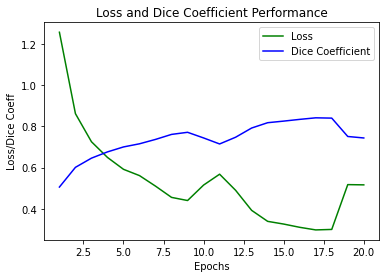

In [23]:
n_epochs = len(history.history['loss'])
loss = history.history['loss']
dice_coeff = history.history['dice_coefficient']
epochs = range(1,n_epochs+1)
plt.plot(epochs, loss, 'g', label='Loss')
plt.plot(epochs, dice_coeff , 'b', label='Dice Coefficient')
plt.title('Loss and Dice Coefficient Performance')
plt.xlabel('Epochs')
plt.ylabel('Loss/Dice Coeff')
plt.legend()
plt.show()

In [74]:
best_epochs = np.argmin(history.history['loss']) + 1
print('We achieve the best results at ', best_epochs, 'epoch with minimum loss: %0.4f' %history.history['loss'][best_epochs-1],'and dice coefficient observed: %0.4f' %history.history['dice_coefficient'][best_epochs-1])

We achieve the best results at  17 epoch with minimum loss: 0.2968 and dice coefficient observed: 0.8420


#### 4. Prediction using the model:

In [75]:
m = np.random.randint(9)
pred_mask = cv2.resize(1.0 * (model.predict(x=np.array([X_test[m]]))[0] > 0.5), (IMAGE_WIDTH, IMAGE_HEIGHT)) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


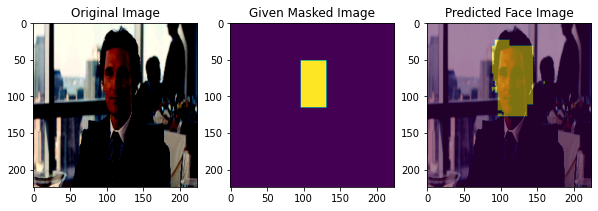

In [76]:
plt.figure(figsize=(10, 30))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(X_test[m]) # original image
plt.subplot(1, 3, 2)
plt.title("Given Masked Image")
plt.imshow(y_test[m])
plt.subplot(1, 3, 3)
plt.title("Predicted Face Image")
plt.imshow(X_test[m])
plt.imshow(pred_mask, alpha=0.5)

Model is able to detect and predict face from the test image

In [26]:
# test the same on new given image
test_img_path = '/gdrive/MyDrive/ACV Project 1 Dataset /Prediction_Image.jpeg'
test_img = tf.keras.preprocessing.image.load_img(test_img_path)
img_array = tf.keras.preprocessing.image.img_to_array(test_img).astype('uint8')
img = cv2.resize(img_array, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
img = preprocess_input(np.array(img, dtype=np.float32))
#test_img = tf.keras.preprocessing.image.load_img(test_img_path, color_mode='grayscale',target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
#test_img = tf.keras.preprocessing.image.img_to_array(test_img).astype('uint8')/255.0
#test_img
#pred_mask = cv2.resize(1.0 * (model.predict(x=test_img)[0] > 0.5), (IMAGE_WIDTH, IMAGE_HEIGHT)) 
pred_mask = cv2.resize(1.0 * (model.predict(x=np.array([img]))[0] > 0.5), (IMAGE_WIDTH, IMAGE_HEIGHT)) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


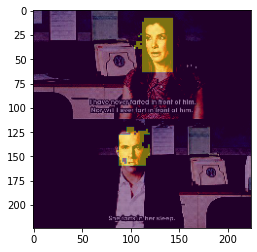

In [27]:
plt.imshow(img)
plt.imshow(pred_mask, alpha=0.5)

### PART 2:

Task: Help to create an image dataset to be used by the AI team to build an image classifier data. there were no seperate dataset given. We have used the same module dataset for part2 as well


* Lets save the images and masks from the earlier module in the respective folder. 
* Will carry out annotation for the original images and save them to in seperate folder

In [42]:
os.makedirs('images') # directory to save original images

In [43]:
os.makedirs('masks') # directory to save mask images for class 'face'

In [44]:
db = pd.DataFrame(columns = ['filename', 'width', 'height','class', 'xmin','ymin','xmax','ymax']) #db for original data as given

In [45]:
# Here we convert numpyarray to images and save them in images folder
fileid = 1
for i in range(data.shape[0]):
  filename = str(fileid) + '.png'
  mask = np.zeros(data[i][0].shape).astype(int)
  cv2.imwrite('images/' + filename,cv2.cvtColor(data[i][0],cv2.COLOR_RGB2BGR))
  fileid += 1
  for j in range(len(data[i][1])):
    height = data[i][1][j]['imageHeight']
    width = data[i][1][j]['imageWidth']
    class_label = data[i][1][j]['label'][0]
    xmin = round((data[i][1][j]['points'][0]['x'])*width)
    ymin = round((data[i][1][j]['points'][0]['y'])*height)
    xmax = round((data[i][1][j]['points'][1]['x'])*width)
    ymax = round((data[i][1][j]['points'][1]['y'])*height)
    mask[ymin:ymax, xmin:xmax] = 1
    row_num= db.shape[0]
    db.loc[row_num,:] = [filename,width,height,class_label,xmin,ymin,xmax,ymax]
  cv2.imwrite('masks/' + filename, mask*255)

In [46]:
db # captured as given

,filename,width,height,class,xmin,ymin,xmax,ymax
0,1.png,650,333,Face,56,102,112,151
1,1.png,650,333,Face,379,97,428,156
2,2.png,1280,697,Face,903,162,985,252
3,3.png,460,240,Face,216,12,279,80
4,3.png,460,240,Face,289,2,343,74
...,...,...,...,...,...,...,...,...
1127,409.png,656,493,Face,164,122,187,150
1128,409.png,656,493,Face,318,115,346,159
1129,409.png,656,493,Face,389,156,407,177
1130,409.png,656,493,Face,507,204,526,226


In [47]:
img_dir = "/content/detection/images"
dir_list = next(os.walk(img_dir))[2]
len(dir_list)

409

#### 1. Annotations - Curate bounding box coordinates for each image

In [49]:
ann_db = pd.DataFrame(columns = ['filename', 'faces_detected','x','y','w','h']) #db for original data as given

In [50]:
for i in range (1,len(dir_list)+1,1):
  print("Execution loop=",i)
  # Create a cascade classfier object
  face_cascade = cv2.CascadeClassifier('/gdrive/MyDrive/Colab Notebooks/ACV/haarcascade_frontalface_default.xml') # use opencv facedetection classifier
  
  filename = str(i) + '.png'
  data_path = os.path.join(img_dir,filename)
  img=cv2.imread(data_path)
  faces=face_cascade.detectMultiScale(img,scaleFactor=1.05,minNeighbors=5)
  
  j=0 
  length=len(faces)
  if length==0:
    print('NIL face detected for image:',filename)
  else:
    #print(len(faces))
    #print(filename)
    # Find coordinates of the face
    for j in range(len(faces)):
      x,y,w,h = faces[j]
      img=cv2.rectangle(img,(x,y),(x+w,y+h),(255, 0, 0),2)
      #print(x,"|",y,"|",w,"|",h ,"|",len(faces),"|",filename)
      row_num= ann_db.shape[0]
      ann_db.loc[row_num,:] = [filename,len(faces),x,y,w,h]

Execution loop= 1
Execution loop= 2
Execution loop= 3
Execution loop= 4
Execution loop= 5
Execution loop= 6
Execution loop= 7
Execution loop= 8
Execution loop= 9
Execution loop= 10
NIL face detected for image: 10.png
Execution loop= 11
Execution loop= 12
Execution loop= 13
Execution loop= 14
Execution loop= 15
Execution loop= 16
Execution loop= 17
Execution loop= 18
Execution loop= 19
Execution loop= 20
Execution loop= 21
Execution loop= 22
NIL face detected for image: 22.png
Execution loop= 23
Execution loop= 24
Execution loop= 25
Execution loop= 26
Execution loop= 27
Execution loop= 28
Execution loop= 29
Execution loop= 30
Execution loop= 31
Execution loop= 32
Execution loop= 33
Execution loop= 34
Execution loop= 35
Execution loop= 36
Execution loop= 37
Execution loop= 38
Execution loop= 39
Execution loop= 40
Execution loop= 41
NIL face detected for image: 41.png
Execution loop= 42
Execution loop= 43
Execution loop= 44
Execution loop= 45
Execution loop= 46
Execution loop= 47
Executio

In [51]:
ann_db

,filename,faces_detected,x,y,w,h
0,1.png,2,380,94,55,55
1,1.png,2,59,95,53,53
2,2.png,2,891,146,103,103
3,2.png,2,67,513,56,56
4,3.png,3,265,6,62,62
...,...,...,...,...,...,...
1815,409.png,5,215,150,46,46
1816,409.png,5,435,192,32,32
1817,409.png,5,105,243,34,34
1818,409.png,5,533,270,27,27


In [124]:
def visualize_output(image_file):
  file_path = '/content/detection/images/'+ image_file
  img = cv2.imread(file_path)
  result = ann_db[ann_db['filename'] == image_file]
  #Draw rectangle for predicted boxes, also add predicted classes  
  if result.empty:
    label = 'Face annotated:NIL'
  else:
    label = 'Face annotated:' + str(result.faces_detected[0])
    for i in range(result.shape[0]):
      #print('hi')
      x = result.x[i]
      y = result.y[i]
      w = result.w[i]
      h = result.h[i]
      img = cv2.rectangle(img, (x, y), (x+w, y+h), (0,255,0), 2)
  print(label)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.figure(figsize=(10,10))
  plt.imshow(img)
  plt.show()

Face annotated:2


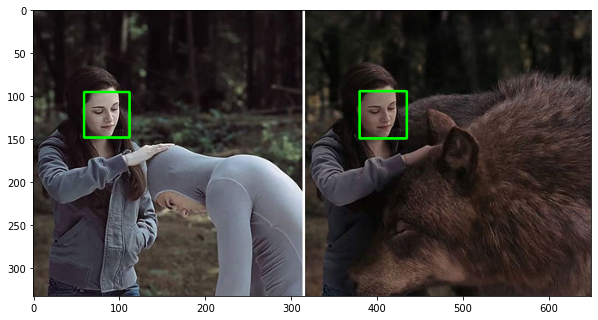

In [127]:
image = '1.png'
visualize_output(image)

#### 2. Save the annotated in json/csv/xls file

In [128]:
#Export coordinates
ann_db.to_excel("Bounding boxes.xlsx")
ann_db.to_csv("Bounding boxes.csv")
ann_db.to_json("Bounding boxes.json")

#### 3. Comment on the challenges faced during this task.

* Manual annotation is a tedious job especially when it is to be used for semantic segmentation. It also depends upon the person annotating. Like image with batman in it may be annotated as person face based on person thoughts.
* To automize we need another model for same purpose (like in this case face classifier).
* Even with opencv classifier we observe that there were images where it was not able to detect faces and those were not annotated.
* Also the annotation for some images were not accurate.
* Even if we annotate we need to manually check the files and annotate the missing entries for better model learning.